# Model evaluation

Draw samples from the neural spline flow model conditioned on GW150914 strain data and compare them to `bilby` samples. Produce P-P plots from injections.

## Imports

In [2]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import h5py
import corner
import time

from lfigw.gwpe import PosteriorModel
import lfigw.waveform_generator as wfg

## Load trained neural conditional density estimator and noisy test data

In [2]:
pm = PosteriorModel(model_dir='../models/GW150914/', data_dir='../waveforms/GW150914/')
pm.load_model()
pm.wfd = wfg.WaveformDataset()
pm.wfd.load_noisy_test_data(pm.data_dir)
pm.init_waveform_supp()

## Posterior distribution for GW150914

### Neural network samples

In [3]:
from lfigw.nde_flows import obtain_samples

In [5]:
# Load strain data for event

event_strain = {}
with h5py.File('../data/events/GW150914/strain_FD_whitened.hdf5', 'r') as f:
    event_strain['H1'] = f['H1'][:].astype(np.complex64)
    event_strain['L1'] = f['L1'][:].astype(np.complex64)

In [6]:
# Project onto reduced basis

d_RB = {}
for ifo, di in event_strain.items():
    h_RB = pm.wfd.basis.fseries_to_basis_coefficients(di)
    d_RB[ifo] = h_RB
_, y = pm.wfd.x_y_from_p_h(pm.wfd.noisy_waveforms_parameters[0], d_RB, add_noise=False)

/data/home/sgreen/miniconda3/envs/gwml/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


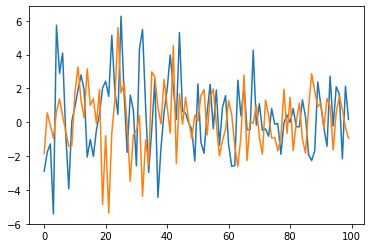

In [7]:
# Plot the strain data (RB representation)

for det, h in d_RB.items():
    plt.plot(h)
plt.show()

#### Draw samples from neural density estimator

In [10]:
nsamples = 50000

start = time.time()
x_samples = obtain_samples(pm.model, y, nsamples, pm.device)
end = time.time()
print(start-end)

x_samples = x_samples.cpu()

# Rescale parameters. The neural network preferred mean zero and variance one. This undoes that scaling.
params_samples = pm.wfd.post_process_parameters(x_samples.numpy())

-10.660233974456787


### Bilby samples

In [11]:
import bilby
%matplotlib inline

In [12]:
# Specify the output directory and the name of the bilby run
outdir = '../bilby_runs/GW150914'
label = 'GW150914'

In [14]:
# Load bilby samples
result = bilby.result.read_in_result(outdir=outdir, label=label)

bilby_samples = result.posterior[['mass_1', 'mass_2', 'phase', 'geocent_time', 'luminosity_distance',
                                  'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                                  'theta_jn', 'psi', 'ra', 'dec']].values

# Shift the time of coalescence by the trigger time
bilby_samples[:,3] = bilby_samples[:,3] - pm.wfd.ref_time

### Weights

Calculate weights for the neural network samples, based on the different distance priors used by `bilby` and the neural network.

In [13]:
distances = params_samples[:,pm.wfd.param_idx['distance']]

# Delete any samples with negative distances
#pos = distances > 0
#distances = distances[pos]
#params_samples = params_samples[pos]

cosmoprior = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance', minimum=1e2, maximum=1e3)

weights = cosmoprior.prob(distances)
weights = weights / np.mean(weights)

### Save samples

In [15]:
np.savez_compressed('../data/posterior_GW150914.npz', samples=params_samples, parameter_labels=pm.wfd.parameter_labels, weights=weights, bilby_samples=bilby_samples)

### Plot results

In [15]:
dom = [[30,55], [20,45], [0, 2*np.pi], [0.015,0.045], [100,800], [0,1], [0,1], [0,np.pi], [0,np.pi], [0, 2*np.pi], [0, 2*np.pi], [0,np.pi], [0,np.pi], [0.6,3.2], [-np.pi/2,.1]]

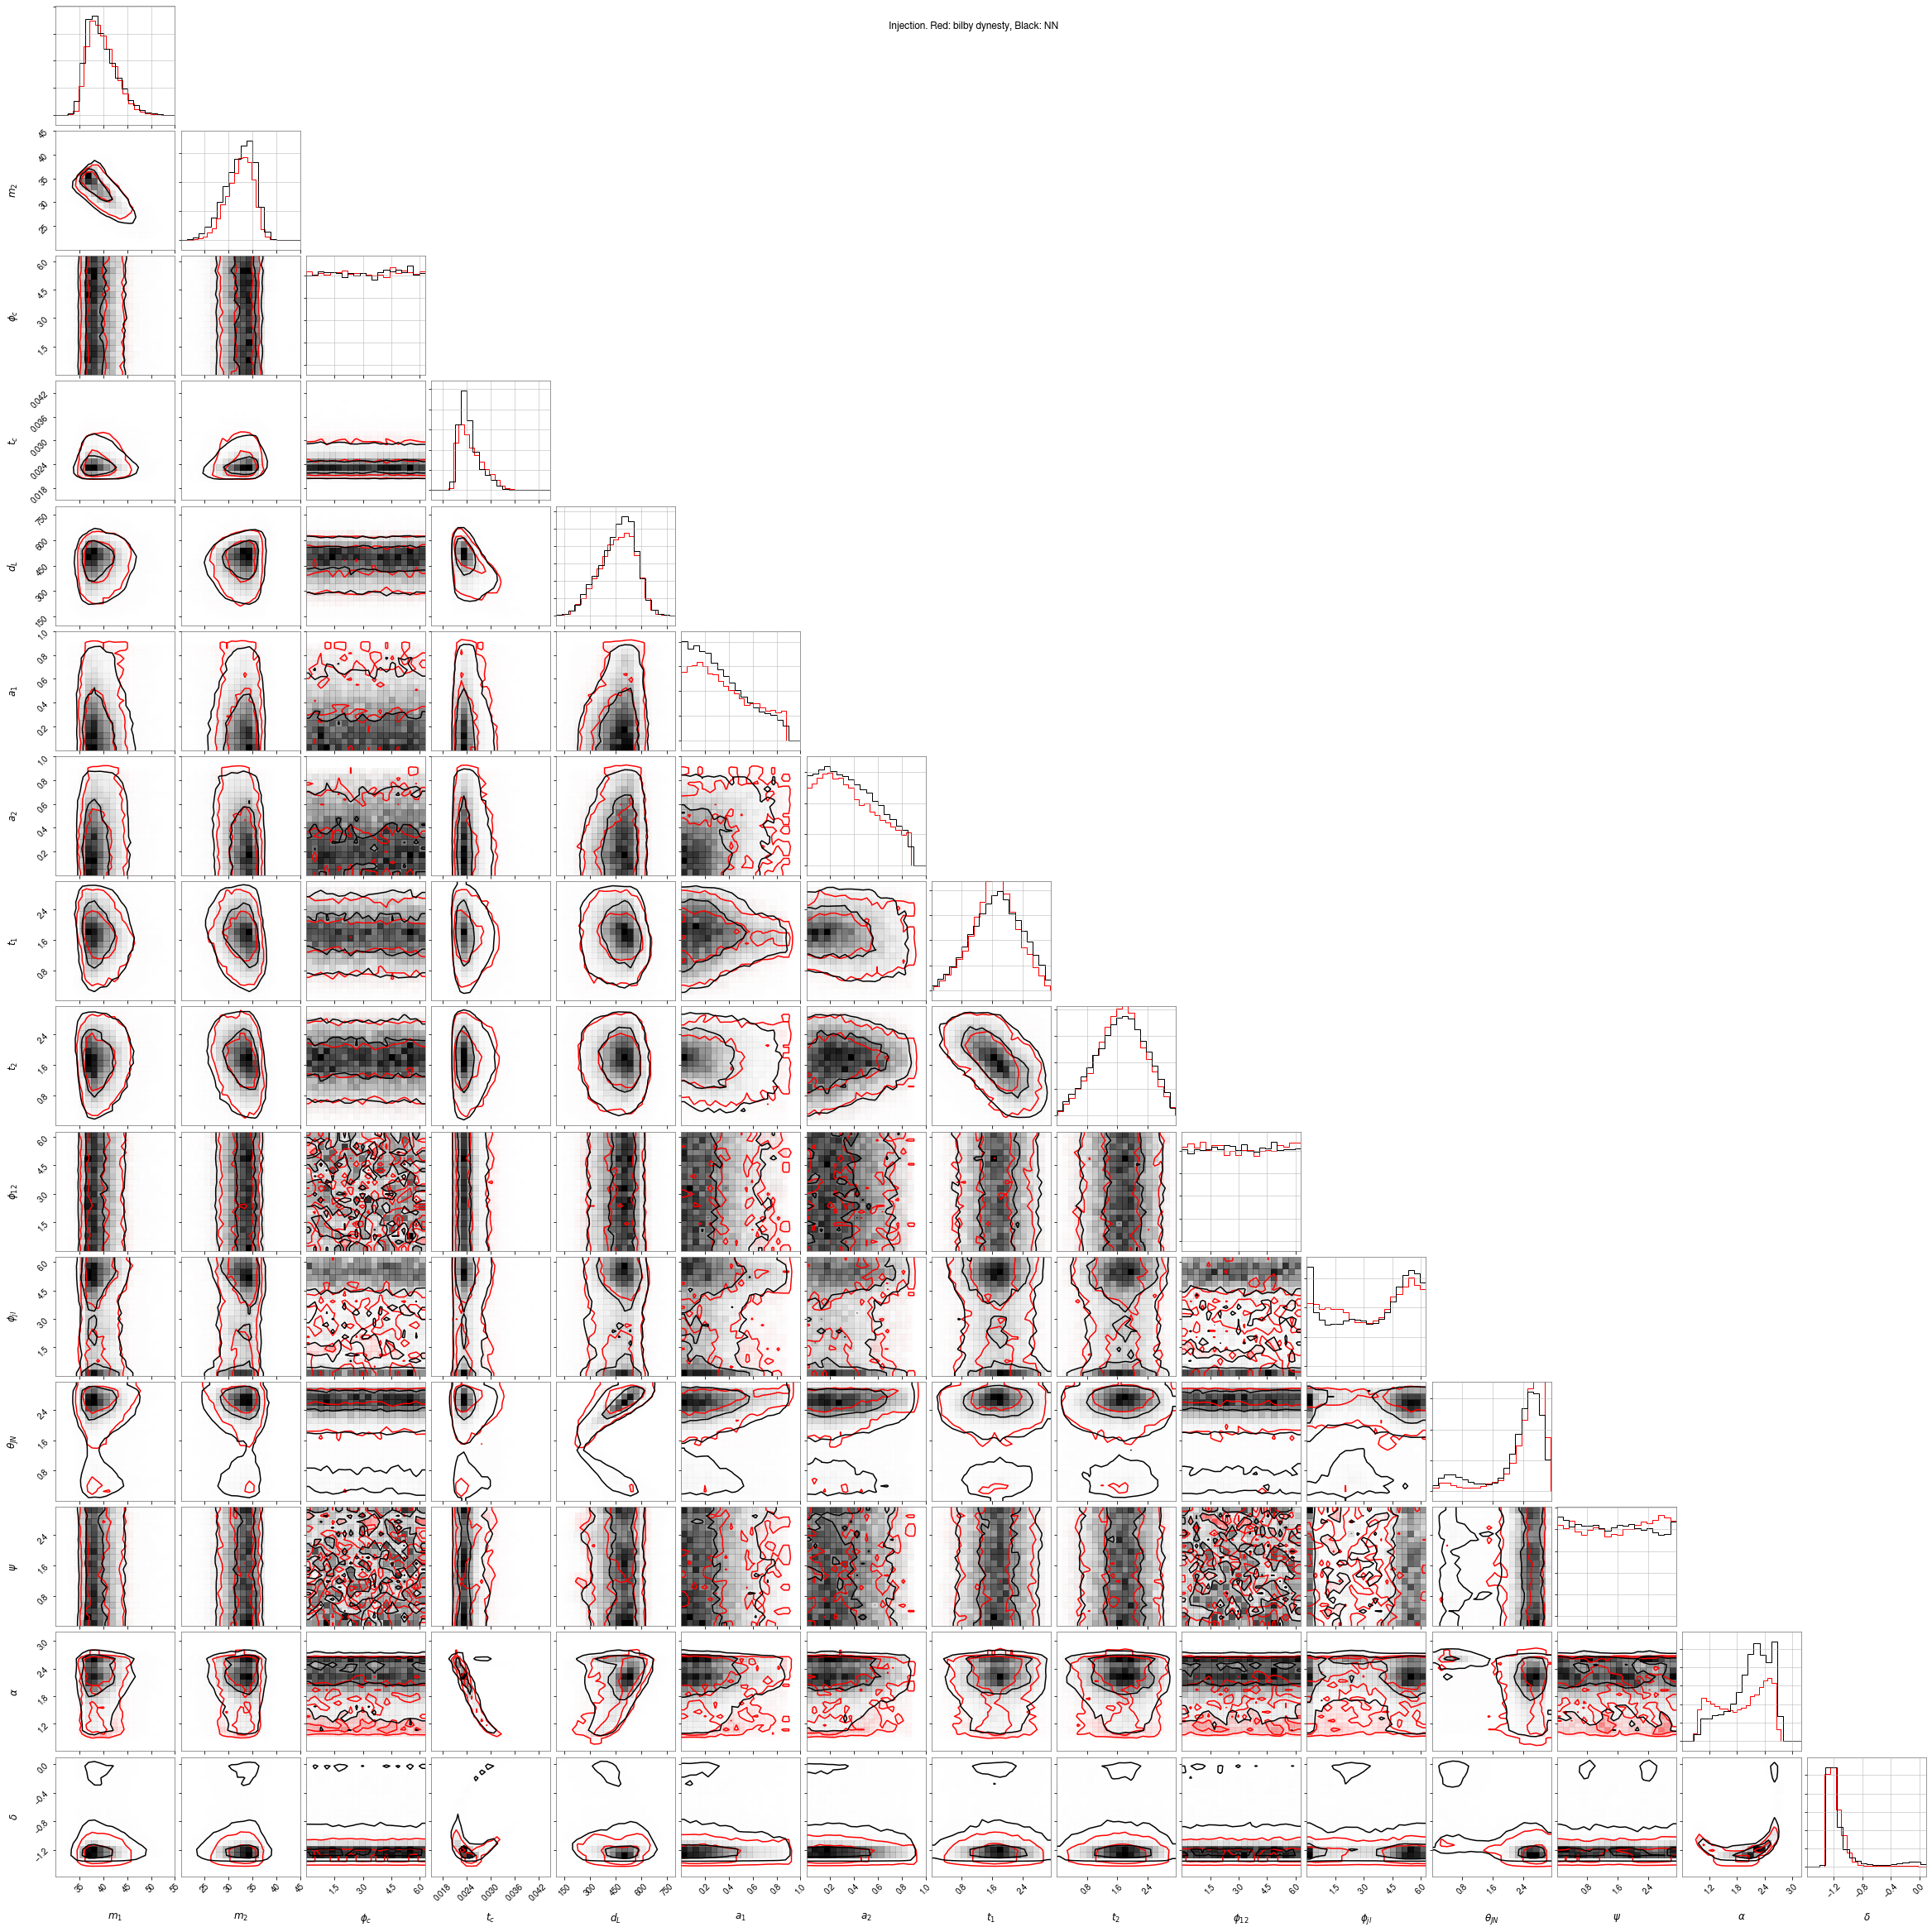

In [16]:
fig = corner.corner(bilby_samples, labels=pm.wfd.parameter_labels, color='red',
                    levels=(0.5,0.9), scale_hist=True, plot_datapoints=False)
corner.corner(params_samples, levels=[0.5, 0.9],
              scale_hist=True, plot_datapoints=False, fig=fig, weights=weights * len(bilby_samples) / len(params_samples), range=dom)
plt.suptitle('Red: bilby dynesty, Black: NN')
plt.show()

## P-P plot

Constructed from a large number of injections of simulated signals into noise realizations. These have been saved in the noisy test data file.

In [4]:
mpl.rcParams['font.size'] = 14

In [5]:
def make_pp(percentiles, parameter_labels, ks=True):
    
    percentiles = percentiles/100.
    nparams = percentiles.shape[-1]
    nposteriors = percentiles.shape[0]

    ordered = np.sort(percentiles, axis=0)
    ordered = np.concatenate((np.zeros((1, nparams)), ordered, np.ones((1, nparams))))
    y = np.linspace(0, 1, nposteriors + 2)
        
    fig = plt.figure(figsize=(10,10))
    
    for n in range(nparams):
        if ks:
            pvalue = stats.kstest(percentiles[:, n], 'uniform')[1]
            plt.step(ordered[:, n], y, where='post', label=parameter_labels[n] + r' ({:.3g})'.format(pvalue))
        else:
            plt.step(ordered[:, n], y, where='post', label=parameter_labels[n])
    plt.plot(y, y, 'k--')
    plt.legend()
    plt.ylabel(r'$CDF(p)$')
    plt.xlim((0,1))
    plt.ylim((0,1))
        
    plt.xlabel(r'$p$')

    ax = fig.gca()
    ax.set_aspect('equal', anchor='SW')
    
    plt.show() 

Perform inference on a large number of injections. This takes a few minutes.

In [ ]:
neval = 100    # number of injections
nparams = pm.wfd.nparams

percentiles = np.empty((neval, nparams))
for idx in tqdm(range(neval)):
    samples = pm.evaluate(idx=idx, nsamples=10000, plot=False)
    parameters_true =  pm.wfd.noisy_waveforms_parameters[idx]
    for n in range(nparams):
        percentiles[idx, n] = stats.percentileofscore(samples[:,n], parameters_true[n])

 41%|████▏     | 106/256 [03:35<05:14,  2.10s/it]

In [ ]:
parameter_labels = pm.wfd.parameter_labels

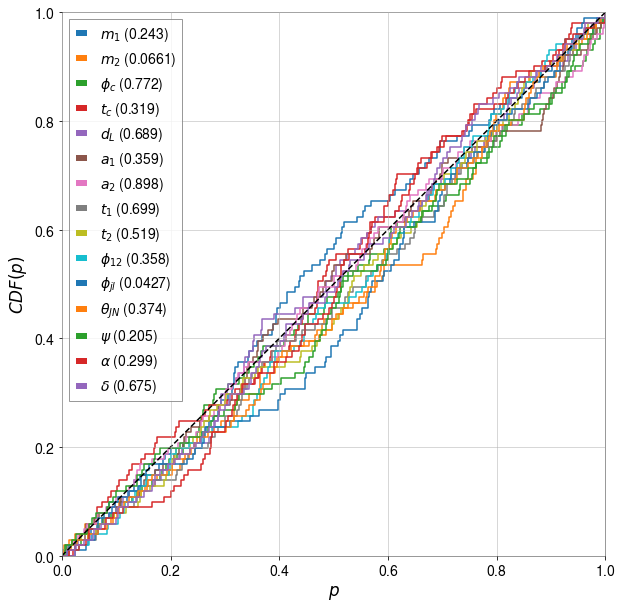

In [22]:
make_pp(percentiles, parameter_labels)

In [23]:
# Save pp plot data.

np.savez_compressed('../data/pp_GW150914.npz', parameter_labels=parameter_labels, percentiles=percentiles)